## Vector Database setup

Remove old Weaviate DB files

In [4]:
!rm -rf ~/.local/share/weaviate

'rm' is not recognized as an internal or external command,
operable program or batch file.



### Step 1 - Download sample data

In [5]:
import requests
import json

# Download the data
resp = requests.get('https://raw.githubusercontent.com/weaviate-tutorials/quickstart/main/data/jeopardy_tiny.json')
data = json.loads(resp.text)  # Load data

# Parse the JSON and preview it
print(type(data), len(data))

def json_print(data):
    print(json.dumps(data, indent=2))

json_print(data[0])

<class 'list'> 10
{
  "Category": "SCIENCE",
  "Question": "This organ removes excess glucose from the blood & stores it as glycogen",
  "Answer": "Liver"
}


### Step 2 - Create an embedded instance of Weaviate vector database

In [ ]:
import weaviate, os
from weaviate import EmbeddedOptions
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

client = weaviate.Client(
    embedded_options=EmbeddedOptions(),
    additional_headers={
        "X-OpenAI-BaseURL": os.environ['OPENAI_API_BASE'],
        "X-OpenAI-Api-Key": openai.api_key  # Replace this with your actual key
    }
)
print(f"Client created? {client.is_ready()}")

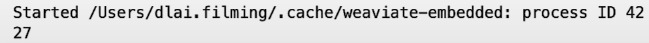

In [ ]:
json_print(client.get_meta())

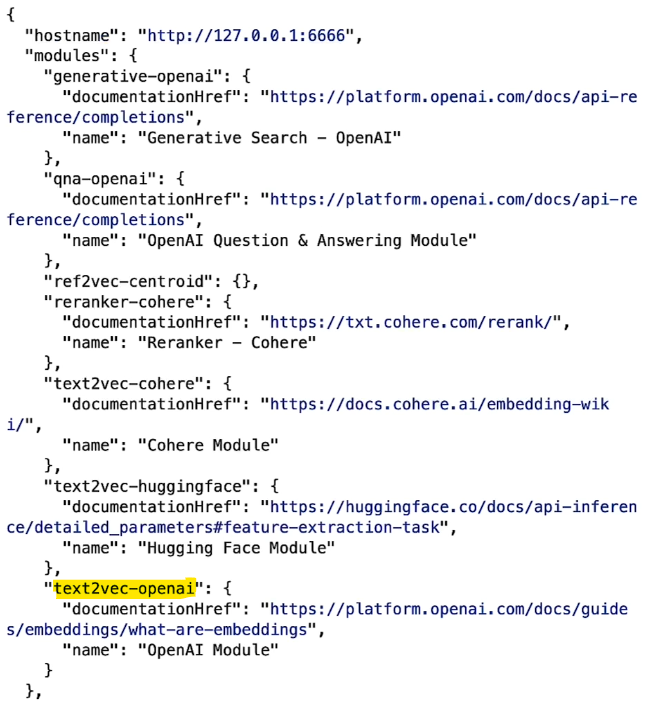

## Step 3 - Create Question collection

In [ ]:
# resetting the schema. CAUTION: This will delete your collection 
if client.schema.exists("Question"):
    client.schema.delete_class("Question")
class_obj = {
    "class": "Question",
    "vectorizer": "text2vec-openai",  # Use OpenAI as the vectorizer
    "moduleConfig": {
        "text2vec-openai": {
            "model": "ada",
            "modelVersion": "002",
            "type": "text",
            "baseURL": os.environ["OPENAI_API_BASE"]
        }
    }
}

client.schema.create_class(class_obj)

## Step 4 - Load sample data and generate vector embeddings

In [ ]:
# reminder for the data structure
json_print(data[0])

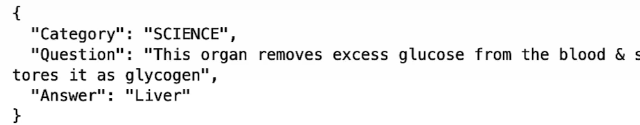

In [ ]:
with client.batch.configure(batch_size=5) as batch: #import data # do not save embedding in the vector database because Text2Vec open AI generates vector embedding for every object
    for i, d in enumerate(data):  # Batch import data
        
        print(f"importing question: {i+1}")
        #construct object
        properties = {
            "answer": d["Answer"],
            "question": d["Question"],
            "category": d["Category"],
        }
        
        batch.add_data_object(
            data_object=properties,
            class_name="Question"
        )

In [ ]:
count = client.query.aggregate("Question").with_meta_count().do()
json_print(count)

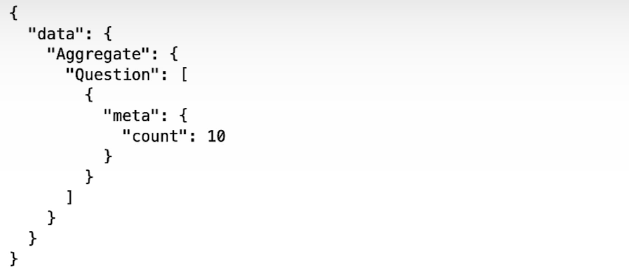

## Let's Extract the vector that represents each question!

In [ ]:
# write a query to extract the vector for a question
result = (client.query
          .get("Question", ["category", "question", "answer"]) #object
          .with_additional("vector") #to show the vector generated
          .with_limit(1)
          .do())

json_print(result)

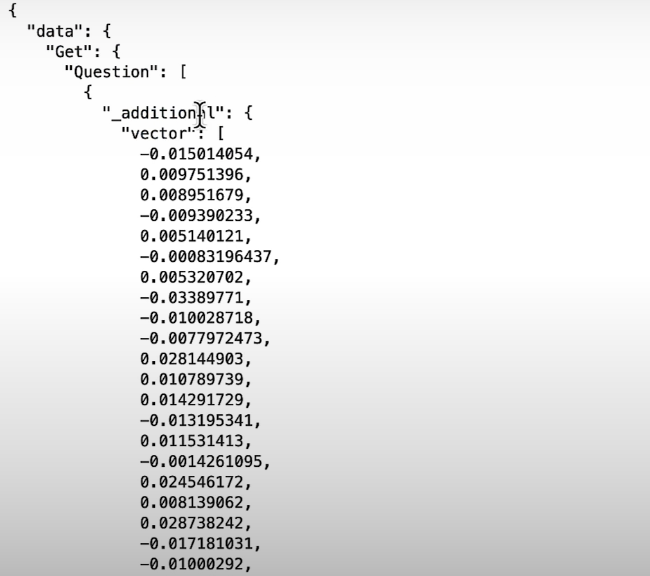

## Query time
What is the distance between the `query`: `biology` and the returned objects?

In [ ]:
##run a vector query using Semanticsearch
response = (
    client.query
    .get("Question",["question","answer","category"])
    .with_near_text({"concepts": "biology"}) ##a vector query using Semanticsearch
    .with_additional('distance') #additional property
    .with_limit(2)
    .do()
)

json_print(response)

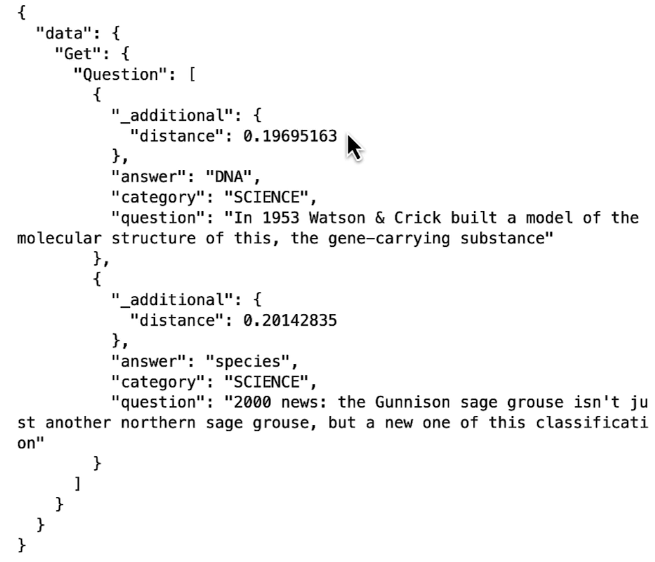

In [ ]:
response = (
    client.query
    .get("Question", ["question", "answer"])
    .with_near_text({"concepts": ["animals"]})
    .with_limit(10)
    .with_additional(["distance"])
    .do()
)

json_print(response)

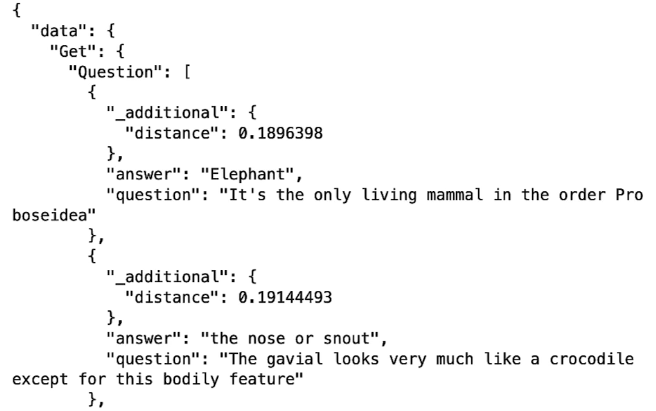

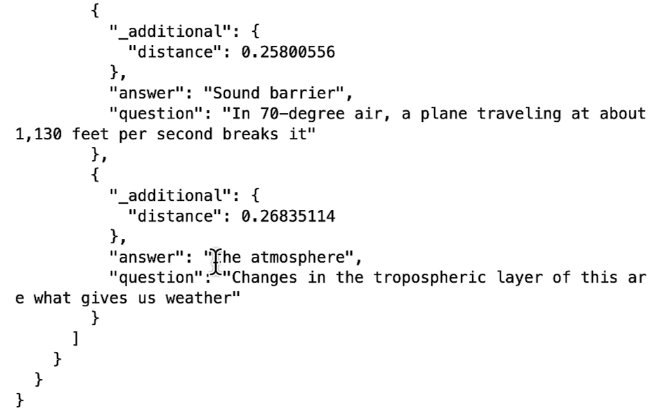

## We can let the vector database know to remove results after a threshold distance!

In [ ]:
response = (
    client.query
    .get("Question", ["question", "answer"])
    .with_near_text({"concepts": ["animals"], "distance": 0.24})
    .with_limit(10)
    .with_additional(["distance"])
    .do()
)

json_print(response)

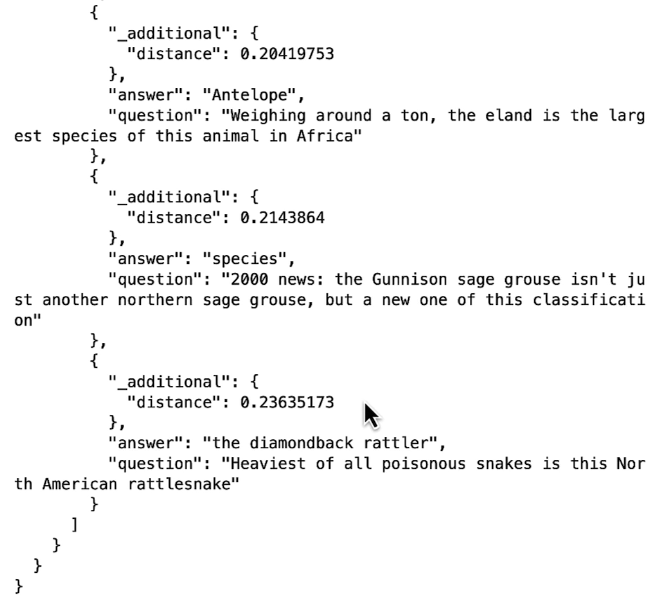

## Vector Databases support for CRUD operations

### Create

In [ ]:
#Create an object
object_uuid = client.data_object.create(
    data_object={
        'question':"Leonardo da Vinci was born in this country.",
        'answer': "Italy",
        'category': "Culture"
    },
    class_name="Question"
 )

In [ ]:
print(object_uuid)

### Read

In [ ]:
data_object = client.data_object.get_by_id(object_uuid, class_name="Question")
json_print(data_object)

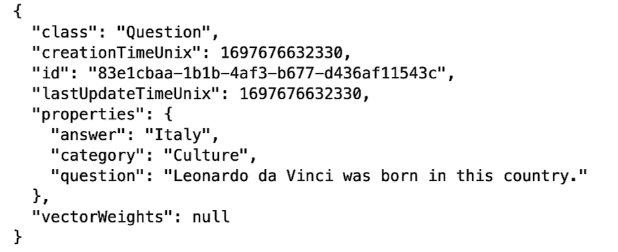

In [ ]:
data_object = client.data_object.get_by_id(
    object_uuid,
    class_name='Question',
    with_vector=True #show the vector embedding generated for the object
)

json_print(data_object)

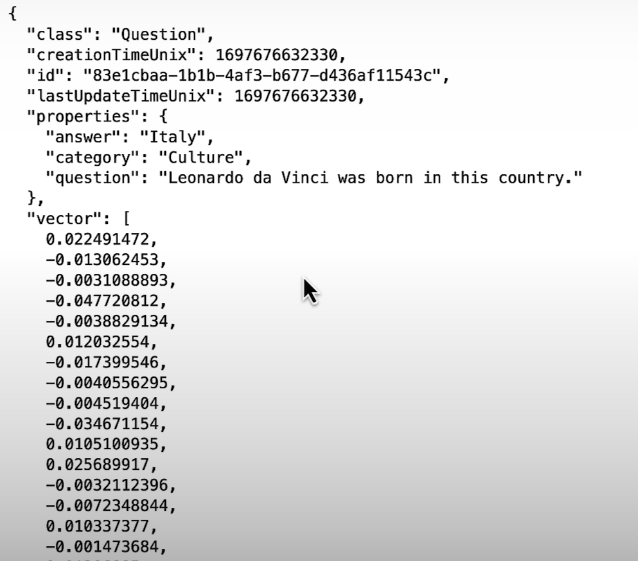

### Update

In [ ]:
client.data_object.update(
    uuid=object_uuid,
    class_name="Question",
    data_object={
        'answer':"Florence, Italy"
    })

In [ ]:
data_object = client.data_object.get_by_id(
    object_uuid,
    class_name='Question',
)

json_print(data_object)

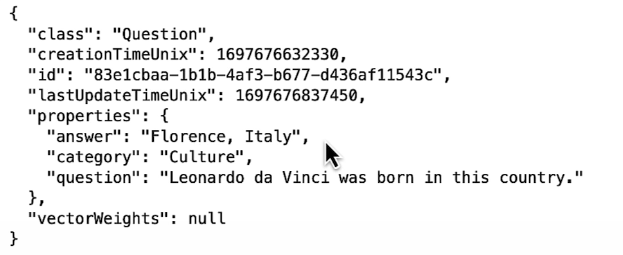

### Delete

In [ ]:
json_print(client.query.aggregate("Question").with_meta_count().do())

In [ ]:
client.data_object.delete(uuid=object_uuid, class_name="Question")

In [ ]:
json_print(client.query.aggregate("Question").with_meta_count().do())